In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [3]:
games = pd.read_csv('games.csv')
turns = pd.read_csv('turns.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

bots_list = ['BetterBot', 'STEEBot', 'HastyBot']

In [4]:
print("games.csv shape:", games.shape)
print("turns.csv shape:", turns.shape)
print("train.csv shape:", train.shape)
print("test.csv shape:", test.shape)
print("sample_submission.csv shape:", sample_submission.shape)

games.csv shape: (72773, 12)
turns.csv shape: (2005498, 9)
train.csv shape: (100820, 4)
test.csv shape: (44726, 4)
sample_submission.csv shape: (22363, 2)


In [5]:
train_game_id = list(train.game_id.unique())
test_game_id = list(test.game_id.unique())

In [6]:
# how many users totally?
user_total = []
for i in range(len(turns)):
    if turns['nickname'][i] not in bots_list:
        user_total.append(turns['nickname'][i])
user_total = list(set(user_total))

print("We have totally {} users".format(len(user_total)))

We have totally 1468 users


In [7]:
# combine train and test into a new dataframe
tain_test = pd.concat([train, test], axis=0)
tain_test

,game_id,nickname,score,rating
0,1,BetterBot,335,1637.0
1,1,stevy,429,1500.0
2,3,davidavid,440,1811.0
3,3,BetterBot,318,2071.0
4,4,Inandoutworker,119,1473.0
...,...,...,...,...
44721,72762,kyjo55555,367,NaN
44722,72768,HastyBot,524,2356.0
44723,72768,Maximilian,357,NaN
44724,72769,STEEBot,626,2110.0


In [8]:
tain_test = tain_test.reset_index()

users = []
bots = []
for i in range(len(tain_test)):
    if tain_test['nickname'][i] in bots_list:
        users.append(np.NaN)
        bots.append(tain_test['nickname'][i])
    else:
        users.append(tain_test['nickname'][i])
        bots.append(np.NaN)
tain_test['user'] = users
tain_test['bot'] = bots

tain_test_users = tain_test[tain_test['user'].notnull()][['user', 'game_id', 'score', 'rating']]
tain_test_bots = tain_test[tain_test['bot'].notnull()][['bot', 'game_id', 'score', 'rating']]

df = tain_test_users.merge(tain_test_bots, how='left', on='game_id')
df = df.rename(
    columns={'score_x': 'user_score', 'rating_x': 'user_rating', 'score_y': 'bot_score', 'rating_y': 'bot_rating'})
df = df[['game_id', 'user', 'bot', 'user_score', 'bot_score', 'bot_rating', 'user_rating']]

In [9]:
# add details from games.csv into the df
game_df = df.merge(games, how='left', on='game_id')

# first
first_num = []
for i in range(len(game_df)):
    if game_df['first'][i] in bots_list:
        first_num.append(0)
    else:
        first_num.append(1)

game_df = game_df.drop('first', axis=1)
game_df['first'] = first_num

In [10]:
game_df_train = game_df[game_df.game_id.isin(train_game_id)]
game_df_test = game_df[game_df.game_id.isin(test_game_id)]

game_df_train_X = game_df_train.drop('user_rating', axis=1)
game_df_train_y = game_df_train[['user_rating']]

game_df_test_X = game_df_test.drop('user_rating', axis=1)
game_df_test_y = game_df_test[['user_rating']]

Feature Engineering

In [11]:
# handle with qualitav features
game_df_train_X_onehot = pd.get_dummies(game_df_train_X,
                                        columns=['bot', 'first', 'time_control_name', 'game_end_reason', 'winner',
                                                 'lexicon', 'rating_mode'])
game_df_train_X_onehot = game_df_train_X_onehot.drop(['user', 'created_at'], axis=1)
game_df_train_X_onehot = game_df_train_X_onehot.set_index('game_id')
game_df_train_X_onehot

,user_score,bot_score,bot_rating,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,bot_BetterBot,bot_HastyBot,bot_STEEBot,...,game_end_reason_TIME,winner_-1,winner_0,winner_1,lexicon_CSW21,lexicon_ECWL,lexicon_NSWL20,lexicon_NWL20,rating_mode_CASUAL,rating_mode_RATED
game_id,,,,,,,,,,,,,,,,,,,,,
1,429,335,1637.0,1200,0,1,674.844274,1,0,0,...,0,0,0,1,0,0,0,1,1,0
3,440,318,2071.0,900,0,5,492.268262,1,0,0,...,0,0,0,1,1,0,0,0,0,1
4,119,478,1936.0,3600,0,1,350.861141,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5,325,427,1844.0,1200,0,1,642.688722,0,0,1,...,0,0,1,0,0,0,0,1,1,0
6,378,427,2143.0,900,0,1,426.950541,0,0,1,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72767,340,414,1952.0,3600,0,1,3669.988413,1,0,0,...,1,0,1,0,1,0,0,0,1,0
72770,97,590,2237.0,3600,0,1,3662.659287,0,1,0,...,1,0,1,0,1,0,0,0,0,1
72771,390,393,1614.0,900,0,10,236.133634,0,1,0,...,0,0,1,0,0,1,0,0,1,0


In [12]:
# standardize the data
from sklearn.preprocessing import StandardScaler

X_standardize_model  = StandardScaler()
y_standardize_model = StandardScaler()


game_df_train_X_onehot_stand = X_standardize_model.fit_transform(game_df_train_X_onehot)
game_df_train_y_stand = y_standardize_model.fit_transform(game_df_train_y)

In [13]:
game_df_train_X_onehot_stand

array([[ 0.72780386, -1.23534979, -1.61594104, ...,  1.66673661,
         1.58335927, -1.58335927],
       [ 0.87903076, -1.47674741,  0.54953626, ..., -0.59997482,
        -0.6315686 ,  0.6315686 ],
       [-3.53404493,  0.79523019, -0.12405691, ..., -0.59997482,
         1.58335927, -1.58335927],
       ...,
       [ 0.19163579, -0.41175791, -1.73070136, ..., -0.59997482,
         1.58335927, -1.58335927],
       [ 0.16413999,  0.28403523, -1.43132662, ...,  1.66673661,
        -0.6315686 ,  0.6315686 ],
       [ 0.09540049, -1.07915133,  1.70212902, ..., -0.59997482,
        -0.6315686 ,  0.6315686 ]])

In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    game_df_train_X_onehot, game_df_train_y, test_size=0.3, random_state=101)

print("X_train shape:", X_train.shape)
print("X_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (35287, 29)
X_train shape: (35287, 1)
X_test shape: (15123, 29)
y_test shape: (15123, 1)


In [15]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_test, y_test, cv=10)
print(regressor.score(X_train,y_train))
print(regressor.score(X_test,y_test))

# Print the feature importances
feature_importances = regressor.feature_importances_
print(feature_importances)

1.0
0.5585348696223196
[1.50583485e-01 4.98885578e-02 4.58070101e-01 7.71178589e-02
 2.20293036e-03 1.99479668e-02 8.76419908e-02 1.35474092e-02
 7.58242977e-03 2.13706939e-03 3.32809910e-03 3.11626303e-03
 3.73801879e-03 3.66681165e-03 1.34612440e-03 7.29414413e-04
 4.68748351e-04 9.43101875e-04 2.96315477e-03 7.04438687e-04
 1.38025248e-04 7.62224368e-04 8.86964178e-04 3.67382654e-02
 2.54912924e-04 1.07618549e-09 2.03071898e-03 6.46183972e-02
 4.84651624e-03]


In [16]:
feature_importances[feature_importances.argsort()[::-1]]

array([4.58070101e-01, 1.50583485e-01, 8.76419908e-02, 7.71178589e-02,
       6.46183972e-02, 4.98885578e-02, 3.67382654e-02, 1.99479668e-02,
       1.35474092e-02, 7.58242977e-03, 4.84651624e-03, 3.73801879e-03,
       3.66681165e-03, 3.32809910e-03, 3.11626303e-03, 2.96315477e-03,
       2.20293036e-03, 2.13706939e-03, 2.03071898e-03, 1.34612440e-03,
       9.43101875e-04, 8.86964178e-04, 7.62224368e-04, 7.29414413e-04,
       7.04438687e-04, 4.68748351e-04, 2.54912924e-04, 1.38025248e-04,
       1.07618549e-09])

In [17]:
regressor.feature_names_in_

array(['user_score', 'bot_score', 'bot_rating', 'initial_time_seconds',
       'increment_seconds', 'max_overtime_minutes',
       'game_duration_seconds', 'bot_BetterBot', 'bot_HastyBot',
       'bot_STEEBot', 'first_0', 'first_1', 'time_control_name_blitz',
       'time_control_name_rapid', 'time_control_name_regular',
       'time_control_name_ultrablitz',
       'game_end_reason_CONSECUTIVE_ZEROES', 'game_end_reason_RESIGNED',
       'game_end_reason_STANDARD', 'game_end_reason_TIME', 'winner_-1',
       'winner_0', 'winner_1', 'lexicon_CSW21', 'lexicon_ECWL',
       'lexicon_NSWL20', 'lexicon_NWL20', 'rating_mode_CASUAL',
       'rating_mode_RATED'], dtype=object)

<AxesSubplot: >

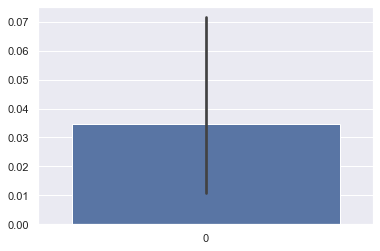

In [18]:
import seaborn as sns

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = regressor.feature_names_in_
sorted_importances = feature_importances[sorted_indices]

df_sea = pd.DataFrame()
df_sea['sorted_indices'] = list(feature_importances.argsort()[::-1])
df_sea['sorted_feature_names'] = list(regressor.feature_names_in_)
df_sea['sorted_importances'] = list(feature_importances)
df_sea=df_sea.sort_values(by=['sorted_importances'],ascending=False)


# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=df_sea, y='sorted_feature_names', x='sorted_importances')

,sorted_indices,sorted_feature_names,sorted_importances
2,6,bot_rating,4.580701e-01
0,2,user_score,1.505835e-01
6,23,game_duration_seconds,8.764199e-02
3,3,initial_time_seconds,7.711786e-02
27,20,rating_mode_CASUAL,6.461840e-02
1,0,bot_score,4.988856e-02
23,15,lexicon_CSW21,3.673827e-02
5,1,max_overtime_minutes,1.994797e-02
7,5,bot_BetterBot,1.354741e-02
8,7,bot_HastyBot,7.582430e-03


<AxesSubplot: xlabel='sorted_importances', ylabel='sorted_feature_names'>

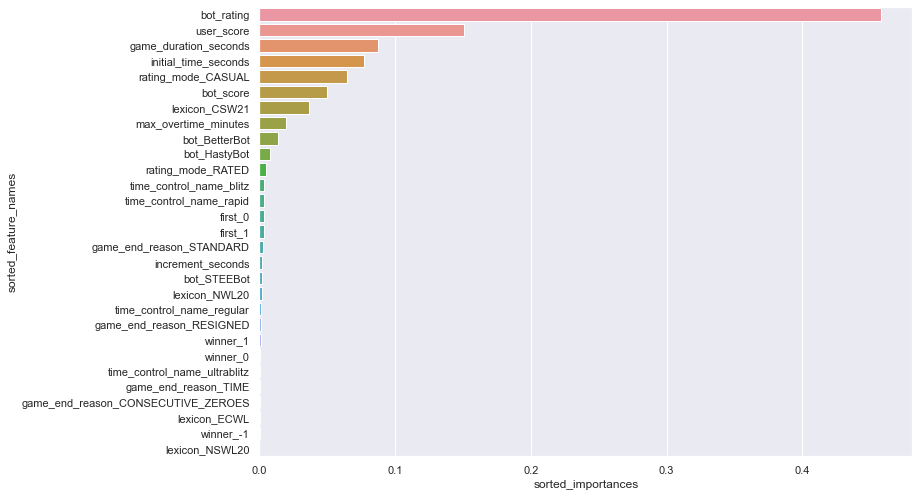

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
rfe = RFE(lr,n_features_to_select=5)
rfe.fit(X_train, y_train)

C:\Users\rr404969\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rr404969\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rr404969\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was

KeyboardInterrupt: 

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)